## SBSA Repairs Insights

In [1]:
import pyspark
from pyspark.sql import SparkSession, types
from pyspark.sql.functions import col, when
from pyspark.sql.types import StructField, StructType
from pyspark.sql.window import Window
import pyspark.sql.functions as F
import numpy as np
import matplotlib.pyplot as plt
import lib.pyspark_helper as helper

In [2]:
spark = SparkSession.builder.master('local[*]').appName('risk').getOrCreate()

### devices not failing

In [3]:
#* read inventory
schema_inventory = StructType([
    StructField('serial_number', types.StringType(), nullable=False),
    StructField('item_type', types.StringType(), nullable=False),
    StructField('status', types.StringType(), nullable=False),
    StructField('date_inserted', types.TimestampType(), nullable=False),
])

df_inventory = spark.read.csv(path='./july_sbsa/sbsa_inventory.csv', schema=schema_inventory, header=True)
df_inventory = df_inventory.withColumn('serial_number', F.substring('serial_number', -15, 15))

df_inventory.printSchema()
df_inventory.show(5, truncate=False)
print('total rows:', df_inventory.count())

root
 |-- serial_number: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- status: string (nullable = true)
 |-- date_inserted: timestamp (nullable = true)

+---------------+------------+---------+-----------------------+
|serial_number  |item_type   |status   |date_inserted          |
+---------------+------------+---------+-----------------------+
|131167213064176|TWE31311672R|Activated|2020-08-17 16:25:00.583|
|131167213064152|TWE31311672R|Activated|2020-08-17 16:25:00.583|
|131167213062902|TWE31311672R|Shipped  |2020-08-17 16:25:00.57 |
|131167213062473|TWE31311672R|Activated|2020-08-17 16:25:00.537|
|131167213062032|TWE31311672R|Activated|2020-08-17 16:25:00.537|
+---------------+------------+---------+-----------------------+
only showing top 5 rows

total rows: 55083


In [4]:
#* read swopout
df_swopout = spark.read.csv(path='./bin/sbsa/swopout_sbsa.csv', inferSchema=True, header=True)
df_swopout = helper.format_col_name(df_swopout)
df_swopout = df_swopout.withColumnRenamed('returning_serial_number', 'serial_number')
df_swopout = df_swopout.withColumn('serial_number', F.substring('serial_number', -15, 15))\
    .withColumn('date', F.to_timestamp('date'))\
    .withColumn('last_dispatch', F.to_timestamp('last_dispatch'))\
    .withColumn('returning_item_age', F.to_timestamp('returning_item_age'))\
    .fillna({'last_dispatch':'1980-01-01 00:00:00'})
df_swopout.printSchema()
df_swopout.show(5, truncate=False, vertical=True)

print('total rows:', df_swopout.count())

root
 |-- event_type: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- last_dispatch: timestamp (nullable = true)
 |-- reason: string (nullable = true)
 |-- serial_number: string (nullable = true)
 |-- returning_item_type: string (nullable = true)
 |-- returning_item_age: timestamp (nullable = true)
 |-- outgoing_serial_number: string (nullable = true)
 |-- outgoing_item_type: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- waybill: string (nullable = true)
 |-- swopout_count: integer (nullable = true)

-RECORD 0----------------------------------------------------------
 event_type             | Item Swopped Out                         
 date                   | 2019-01-02 08:21:49.713                  
 last_dispatch          | 2018-11-27 16:56:14.773                  
 reason                 | Terminal Tampered With                   
 serial_number          | 14069PP20177934                          
 returning_item_type    | Ingenico IPP 35

In [5]:
#* read field items
df_items = spark.read.csv(path='./july_sbsa/sbsa_items.csv', inferSchema=True, header=True)
df_items = helper.format_col_name(df_items)\
    .withColumn('last_connected', F.to_timestamp('last_connected'))
df_items = df_items.withColumn('serial_number', F.substring('serial_number', -15, 15))\
    .filter(col('account_number') == 'SBS009')\
    .select('serial_number','user_name', 'item_type', 'last_connected')\
    .withColumn('offline_duration', F.datediff(F.current_date(), 'last_connected'))

df_items.printSchema()
print('total rows:', df_items.count())
df_items.show(5, truncate=False)

root
 |-- serial_number: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- last_connected: timestamp (nullable = true)
 |-- offline_duration: integer (nullable = true)

total rows: 8340
+---------------+-----------------------------------------+--------------------------------+-----------------------+----------------+
|serial_number  |user_name                                |item_type                       |last_connected         |offline_duration|
+---------------+-----------------------------------------+--------------------------------+-----------------------+----------------+
|18089WL84035343|BP WESTMEAD(PINEMAHA2R)                  |Ingenico iWL 255 01T3524A [SBSA]|2021-05-29 05:24:13.34 |34              |
|17196WL26393514|BP GLENFAIR SERVICE STATION (LYNNLYNA3R) |Ingenico iWL 255 01T3524A [SBSA]|2021-05-26 07:15:05.26 |37              |
|18332WL84551458|VILLAGE ROAD MOTORS (KLOOVILA2R)         |Ingenico iWL 255 01T352

In [6]:
df_no_fail = df_inventory.join(
    df_swopout,
    on='serial_number',
    how='anti'
)

print('total rows:', df_no_fail.count())
df_no_fail.show(5, truncate=False)
df_no_fail.groupBy('item_type').count().sort('count', ascending=False).show()

# df_no_fail.toPandas().to_csv('july_sbsa/no_fail_items.csv', index=False)

total rows: 48091
+---------------+------------+---------+-----------------------+
|serial_number  |item_type   |status   |date_inserted          |
+---------------+------------+---------+-----------------------+
|131167213064176|TWE31311672R|Activated|2020-08-17 16:25:00.583|
|131167213064152|TWE31311672R|Activated|2020-08-17 16:25:00.583|
|131167213062902|TWE31311672R|Shipped  |2020-08-17 16:25:00.57 |
|131167213062473|TWE31311672R|Activated|2020-08-17 16:25:00.537|
|131167213062032|TWE31311672R|Activated|2020-08-17 16:25:00.537|
+---------------+------------+---------+-----------------------+
only showing top 5 rows

+--------------------+-----+
|           item_type|count|
+--------------------+-----+
|Ingenico ICT 220 ...|11646|
|iWL Charging Base...|10429|
|Ingenico iWL 221 ...| 9927|
|        TWE31311672R| 7964|
|Ingenico iWL 255 ...| 6728|
|Ingenico IPP 220 ...|  596|
|Ingenico iWL 222 ...|  230|
|iWL Charging Base...|  229|
|Ingenico IPP220 0...|  162|
|Ingenico iWL 221 ...|  

+--------------------+-----+
|           item_type|count|
+--------------------+-----+
|        TWE31311672R| 7964|
|Ingenico IPP220 0...|  162|
|Ingenico iWL 220 ...|    5|
|iWL Charging Base...|  229|
|Ingenico iWL 221 ...| 9927|
|TWE31310403C_MOVE...|   14|
|Ingenico iWL 221 ...|  161|
|Ingenico IPP 220 ...|  596|
|Ingenico iWL 255 ...| 6728|
|Ingenico ICT 220 ...|11646|
|Ingenico iWL 222 ...|  230|
|iWL Charging Base...|10429|
+--------------------+-----+



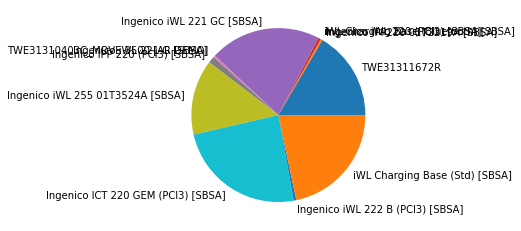

In [7]:
df_no_fail.groupBy('item_type').count().show()
helper.plot_pie(df_no_fail.groupBy('item_type').count(), 'count', 'item_type')

### dispatch vs swopout vs received

In [8]:
df_dispatched = spark.read.csv(path='./bin/sbsa/dispatched_sbsa.csv', inferSchema=True, header=True)
df_dispatched = helper.format_col_name(df_dispatched)
df_dispatched.printSchema()
print('total rows:', df_dispatched.count())

root
 |-- event_type: string (nullable = true)
 |-- date: string (nullable = true)
 |-- last_dispatch: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- returning_serial_number: string (nullable = true)
 |-- returning_item_type: string (nullable = true)
 |-- returning_item_age: string (nullable = true)
 |-- outgoing_serial_number: string (nullable = true)
 |-- outgoing_item_type: string (nullable = true)
 |-- merchant: string (nullable = true)

total rows: 76602


In [9]:
df_received = spark.read.csv(path='./bin/sbsa/received_sbsa.csv', inferSchema=True, header=True)
df_received = helper.format_col_name(df_received)
df_received.printSchema()
print('total rows:', df_received.count())

root
 |-- event_type: string (nullable = true)
 |-- date: string (nullable = true)
 |-- last_dispatch: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- returning_serial_number: string (nullable = true)
 |-- returning_item_type: string (nullable = true)
 |-- returning_item_age: string (nullable = true)
 |-- outgoing_serial_number: string (nullable = true)
 |-- outgoing_item_type: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- waybill: string (nullable = true)
 |-- swopout_count: integer (nullable = true)

total rows: 52108


In [10]:
df_dispatch_group = df_dispatched.groupBy('merchant').count().withColumnRenamed('count', 'dispatch')
df_dispatch_group.show()

+--------------------+--------+
|            merchant|dispatch|
+--------------------+--------+
|Bakubung - Lodge ...|       3|
|BP Jozini (JOZIMA...|      21|
|KFC TWIN CITIES K...|       8|
|     BP EVATON NORTH|      16|
|    Dahya's Pharmacy|       4|
|Tsogo Sun - Sunco...|       1|
|BP QUICK SHOP-OUD...|       4|
|Tsogo Sun - Garde...|       3|
| Waterstone Pharmacy|       3|
|  NANDOS KUILS RIVER|       8|
|FINES ADMINISTRAT...|       2|
|           Frame Fun|       1|
|THE ROCK PUB (338...|       1|
|  Volkers Appliances|       2|
|BP MOORE ROAD (BE...|      12|
|The Cross Trainer...|       2|
|BP Heidelberg Roa...|      12|
|KFC ENOCH SONTONG...|       4|
|Tshwane CENTURION...|       6|
|BP ELDOGLEN (CENT...|       6|
+--------------------+--------+
only showing top 20 rows



In [11]:
df_swopout_group = df_swopout.groupBy('merchant').count().withColumnRenamed('count', 'swopout')
df_swopout_group.show()

+--------------------+-------+
|            merchant|swopout|
+--------------------+-------+
|Bakubung - Lodge ...|      3|
|BP Jozini (JOZIMA...|     34|
|KFC TWIN CITIES K...|      8|
|    Dahya's Pharmacy|      4|
|     BP EVATON NORTH|     16|
|Tsogo Sun - Sunco...|      1|
|Tsogo Sun - Garde...|      3|
| Waterstone Pharmacy|      3|
|  NANDOS KUILS RIVER|      8|
|           Frame Fun|      1|
|THE ROCK PUB (338...|      1|
|  Volkers Appliances|      2|
|BP MOORE ROAD (BE...|      1|
|The Cross Trainer...|      2|
|BP Heidelberg Roa...|     11|
|KFC ENOCH SONTONG...|      4|
|Tshwane CENTURION...|      6|
|BP ELDOGLEN (CENT...|     12|
|KFC - Giyani2-Fas...|      4|
|Rocky's Service S...|    180|
+--------------------+-------+
only showing top 20 rows



In [12]:
df_received_group = df_received.groupBy('merchant').count().withColumnRenamed('count', 'received')
df_received_group.show()

+--------------------+--------+
|            merchant|received|
+--------------------+--------+
|  NEWS CAFE NEWTOWN |       8|
|HAVENSIDE BOTTLE ...|       2|
|SAFETY & ALLIED P...|       1|
|OKALONGO SPAZA SHOP |       2|
|SOBEM AFRICAN FOO...|       2|
|Bakubung - Lodge ...|       5|
|BAYANDA BUSINESS ...|       1|
|TSHWANE LICENCING...|       1|
|BP Jozini (JOZIMA...|      19|
| BUTCHER BLOCK FL...|       1|
|               UTURN|       1|
|KFC TWIN CITIES K...|      10|
|HIGH SPIRITS LIQU...|       1|
|     PROTEA TEAROOM |       1|
|  CASHBUILD EMOYENI |       1|
|     E A WHOLESALERS|       1|
|          ALWAYS NEW|       2|
|    Dahya's Pharmacy|       4|
|   KEURSNIT SLAGHUIS|       2|
|       CANINE CRECHE|       1|
+--------------------+--------+
only showing top 20 rows



In [13]:
df_dispatch_ratio = df_swopout_group.join(
    df_dispatch_group,
    on='merchant',
    how='full'
).join(
    df_received_group,
    on='merchant',
    how='full'
).fillna(0)

df_dispatch_ratio.show()

+--------------------+-------+--------+--------+
|            merchant|swopout|dispatch|received|
+--------------------+-------+--------+--------+
| BUTCHER BLOCK FL...|      0|       0|       1|
| ADT SEDGEFIELD     |      0|       0|       1|
|     ALISHER TRADING|      0|       0|       1|
|          ALWAYS NEW|      0|       0|       2|
|    ARONA MANAGEMENT|      0|       0|       1|
|BAYANDA BUSINESS ...|      0|       0|       1|
|      BONGA HARDWARE|      0|       0|       1|
|     BP EVATON NORTH|     16|      16|      14|
|BP Jozini (JOZIMA...|     34|      21|      19|
|BP MOORE ROAD (BE...|      1|      12|       1|
|BP QUICK SHOP-OUD...|      0|       4|       5|
|    BRAA MOVE TAVERN|      0|       0|       1|
|BUZI CASH & CARRY...|      0|       0|       2|
|Bakubung - Lodge ...|      3|       3|       5|
|       CANINE CRECHE|      0|       0|       1|
|  CASHBUILD EMOYENI |      0|       0|       1|
|   CHESA NYAMA BRITS|      0|       0|       2|
|COASTAL HIRE WITBAN

### swopout reasons

In [14]:
df_swopout.printSchema()

root
 |-- event_type: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- last_dispatch: timestamp (nullable = true)
 |-- reason: string (nullable = true)
 |-- serial_number: string (nullable = true)
 |-- returning_item_type: string (nullable = true)
 |-- returning_item_age: timestamp (nullable = true)
 |-- outgoing_serial_number: string (nullable = true)
 |-- outgoing_item_type: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- waybill: string (nullable = true)
 |-- swopout_count: integer (nullable = true)



In [15]:
df_swopout.groupBy('reason').count().sort('count', ascending=False).show(truncate=False)

+-------------------------------+-----+
|reason                         |count|
+-------------------------------+-----+
|Terminal Tampered With         |12105|
|Printer Faulty                 |4574 |
|Power Supply Faulty            |1108 |
|Not Charging                   |1095 |
|Memory Faulty                  |1050 |
|Damaged by User                |998  |
|Modem Faulty                   |907  |
|Card Reader Faulty (Smartcard) |865  |
|<No Observable Defect>         |820  |
|Bank Key Lost                  |805  |
|Dead Terminal                  |640  |
|Keypad Faulty                  |577  |
|Software Download Failed       |410  |
|SIM Faulty                     |214  |
|COM Port Faulty                |135  |
|Card Reader Faulty (Mag Stripe)|93   |
|Screen Broken                  |69   |
|False SIM Lock                 |48   |
|SSL Certificate Not Loaded     |18   |
|Upgrade                        |9    |
+-------------------------------+-----+
only showing top 20 rows



### terminal service length at merchants

In [16]:
df_swopout.printSchema()

root
 |-- event_type: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- last_dispatch: timestamp (nullable = true)
 |-- reason: string (nullable = true)
 |-- serial_number: string (nullable = true)
 |-- returning_item_type: string (nullable = true)
 |-- returning_item_age: timestamp (nullable = true)
 |-- outgoing_serial_number: string (nullable = true)
 |-- outgoing_item_type: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- waybill: string (nullable = true)
 |-- swopout_count: integer (nullable = true)



In [17]:
df_service = df_swopout.select('serial_number', 'date', 'last_dispatch', 'merchant')\
    .withColumn('duration', F.datediff('date', 'last_dispatch')).fillna({'last_dispatch':'1980-01-01 00:00:00'})

# df_service.filter(col('last_dispatch').isNull()).show()
window = Window.partitionBy(df_service['serial_number']).orderBy(df_service['date'].desc())

df_service = df_service.select('*', F.rank().over(window).alias('rank'))\
    .filter(col('rank') <= 1)\

df_service.show(truncate=False)
# df_service.toPandas().to_csv('july_sbsa/service_duration.csv', index=False)

+---------------+-----------------------+-----------------------+----------------------------------------+--------+----+
|serial_number  |date                   |last_dispatch          |merchant                                |duration|rank|
+---------------+-----------------------+-----------------------+----------------------------------------+--------+----+
|13249PP20053405|2021-03-31 13:47:06.57 |2021-03-29 16:15:40.767|KFC UPINGTON Main Street 1522           |2       |1   |
|13259WL20890907|2019-02-06 10:34:26.43 |2018-07-13 11:38:16.51 |TK Filling Station (SEBOBATA4R)         |208     |1   |
|13260WL20896224|2020-09-29 08:45:00.72 |2014-01-23 12:30:04.41 |Palazzo Montecasino (Tsogo Sun)         |2441    |1   |
|13263WL20905203|2019-01-29 14:45:28.903|2018-08-02 16:32:20.86 |Medikist Pharmacy & Medicine Dep        |180     |1   |
|13263WL20907915|2021-05-17 14:25:50.06 |2014-01-17 11:55:17.5  |Southern Sun - Cape Sun (Tsogo Sun)     |2677    |1   |
|13326CT21185446|2019-05-20 16:2

### terminal usage

In [18]:
df_inventory.printSchema()

root
 |-- serial_number: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- status: string (nullable = true)
 |-- date_inserted: timestamp (nullable = true)



In [19]:
df_items.groupBy('user_name').count().show(truncate=False)

+-------------------------------------------+-----+
|user_name                                  |count|
+-------------------------------------------+-----+
|BP QUICK SHOP-OUDTSHOORN (OUDTVOOA1R)      |4    |
|BP MOORE ROAD (BEREMOOA2R)                 |25   |
|BP Jozini (JOZIMAIA2R)                     |8    |
|BP ELDOGLEN (CENTWILA3R)                   |12   |
|BP Heidelberg Road (CITYHEIA3R)            |7    |
|Rocky's Service Station (BP) (GRASKLIA1R)  |30   |
|Mooi Street Auto Fitment (JOHAMOOA3R)      |26   |
|BP PRINCE GEORGE DRIVE ((RETRPRIA1R)       |14   |
|BP THUSANONG (WELKTHAA4R) NEW              |5    |
|Brighton Motors (KRAABRIA1R)               |19   |
|Queensburgh Auto Centre (BP) (MALVMAIA2R)  |21   |
|Rondebosch Motors (BP) (RONDMAIA1R)        |12   |
|MAOKENG FILLING STATION (BP) (KROOMAOA4R)  |7    |
|Valley Motors (NOORIREA1R)                 |22   |
|RANDFONTEIN [BP] (RANDSIXA4R)              |9    |
|BP Hebron (HEBRLUCA4R)                     |13   |
|BP PINEHURS